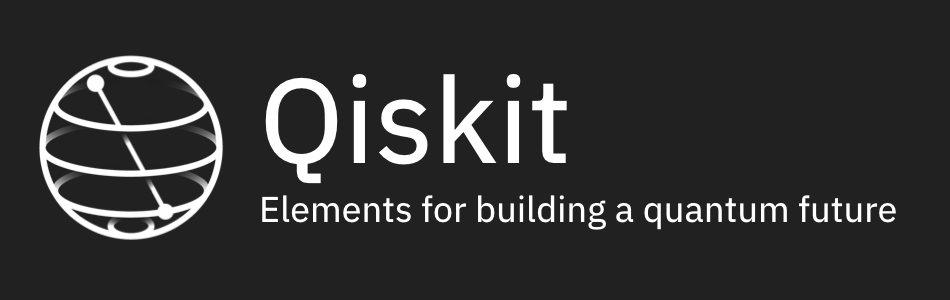

# Creating a new provider


## Introduction

Qiskit Terra is a software for generating quantum circuits, running them on a simulator or device (referred to as a "backend"), and processing the result. For a backend to work with Qiskit, it should be able to process a quantum circuit, which Qiskit passes as a ``Qobj``, and return a ``Job``. The ``Job`` allows for asynchronously tracking the run and returning a ``Result`` once complete.

To simplify the addition of backends, Qiskit defines an interface that can be created by inheriting from ``BaseBackend`` and ``BaseJob``. Backends can then be grouped together and managed by inheriting from ``BaseProvider``.

This tutorial explains how to create a Qiskit backend that wraps an external simulator. We can run the external simulator while enjoying the benefits of polymorphism and a uniform API across simulators.

## An external simulator for this tutorial

We shall construct a very simple simulator. The simulator accepts only a single quantum circuit, where all the gates are Hadamard gates, and all qubits are measured at the end. The input format is a list of qubits on which Hadamard gates are applied. The simulator returns the counts of each basis state, in the form of a list, where the basis states are assumed to be ordered lexicographically.

In [1]:
def run_hadamard_simulator(number_of_qubits, list_of_qubits, shots):
    '''
    Run our amazing Hadamard simulator!
    Note: this function is not designed to be efficient
    
    Args:
        number_of_qubits (integer): number of qubits in the qunatum circuit
        list_of_qubits (list of integers): a list of qubits on whom Hadamard gates are applied
        shots (integer): number of shots

    Returns:
        list of integers:
            each entry in the list contains the number of shots 
            where the measurement result is the correspnding basis state;
            basis states are ordered lexicographically
    '''
    
    # For each qubit, store whether it is manipulated by an odd number of Hadamard gates
    # Example: for run_hadamard_simulator(5, [3, 1, 3, 4], 100)
    # we obtain hadamard_list:
    # [0, 1, 0, 0, 1]
    # because qubits 1 and 4 have an odd number of Hadamard gates.
    hadamard_list = [0]*number_of_qubits
    for qubit in list_of_qubits:
        hadamard_list[qubit] = (1 + hadamard_list[qubit])%2
    
    # Calculate the result for each basis state
    result = [int(shots/(2**hadamard_list.count(1)))]*(2**number_of_qubits)
    for i in range(2**number_of_qubits):
        # Example: when i is 2, 
        # the basis_state is 01000
        basis_state = '{0:b}'.format(i).zfill(number_of_qubits)[::-1]
        
        for qubit in range(number_of_qubits):
            if hadamard_list[qubit] == 0 and basis_state[qubit] == '1':
                result[i] = 0
                break
                
    return result


run_hadamard_simulator(4, [3, 1, 3, 2], 1024)

[256, 0, 256, 0, 256, 0, 256, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Creating a job class

A job class is a necessary building block when creating a provider. It allows to synchronize different executions of the simulator. Since this is out of the scope of this tutorial, we define a degenerated job, which effectively does nothing. See [The IBM Q Provider](../../fundamentals/3_the_ibmq_account.ipynb#The-Provider-) for relevant information.

In [2]:
from qiskit.providers import BaseJob

class HadamardJob(BaseJob):
    def __init__(self, backend):
        super().__init__(backend, 1)
        
    def result(self):
        return self._result
    
    def cancel(self):
        pass
    
    def status(self):
        pass
    
    def submit(self):
        pass

# Creating a backend


In [3]:
from qiskit.providers import BaseBackend
from qiskit.providers.models import BackendConfiguration
from qiskit import qobj as qiskit_qobj
from qiskit.result import Result


class HadamardSimulator(BaseBackend):
    '''
    A wrapper backend for the Hadamard simulator
    '''

    def __init__(self, provider=None):
        configuration = {
            'backend_name': 'hadamard_simulator',
            'backend_version': '0.1.0',
            'url': 'http://www.i_love_hadamard.com',
            'simulator': True,
            'local': True,
            'coupling_map': None,
            'description': 'Simulates only Hadamard gates',
            'basis_gates': ['h', 'x'],  # basis_gates must contain at least two gates
            'memory': True,
            'n_qubits': 30,
            'conditional': False,
            'max_shots': 100000,
            'open_pulse': False,
            'gates': [
                {
                    'name': 'TODO',
                    'parameters': [],
                    'qasm_def': 'TODO'
                }
            ]
        }
        
        # We will explain about the provider in the next section
        super().__init__(configuration=BackendConfiguration.from_dict(configuration),
                         provider=provider)


    def run(self, qobj):
        """Run qobj

        Args:
            qobj (QObj): circuit description

        Returns:
            HadamardJob: derived from BaseJob
        """
        hadamard_job = HadamardJob(None)
            
        experiment_results = []
        for circuit_index, circuit in enumerate(qobj.experiments):
            number_of_qubits = circuit.config.n_qubits
            shots = qobj.config.shots
            
            list_of_qubits = []
            for operation in circuit.instructions:
                if getattr(operation, 'conditional', None):
                    raise QiskitError('conditional operations are not supported '
                                      'by the Hadamard simulator')
                if operation.name != 'h':
                    if operation.name == 'measure':
                        continue
                    else:
                        raise QiskitError('The Hadamrd simulator allows only Hadamard gates')
                
                list_of_qubits.append(operation.qubits[0])
            
            # Need to verify that 
            # all the qubits are measured, and to different classical registers.
            # Raise an error otherwise.
            # We skip this part here.            
            
            counts = run_hadamard_simulator(number_of_qubits, list_of_qubits, shots)
            
            formatted_counts = {}
            for i in range(2**number_of_qubits):
                if counts[i] != 0:
                    formatted_counts[hex(i)] = counts[i]
                           
            experiment_results.append({
                'name': circuit.header.name,
                'success': True, 
                'shots': shots, 
                'data': {'counts': formatted_counts},
                'header': circuit.header.to_dict()
            })
                        
        hadamard_job._result = Result.from_dict({
            'results': experiment_results,
            'backend_name': 'hadamard_simulator',
            'backend_version': '0.1.0',
            'qobj_id': '0',
            'job_id': '0',
            'success': True
        })
        
        return hadamard_job

Congratulations, your backend is ready! Now you can create a Qiskit circuit and run your simulator:

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.transpiler import PassManager

qreg = QuantumRegister(4)
creg = ClassicalRegister(4)
qc = QuantumCircuit(qreg, creg)
qc.h(qreg[3])
qc.h(qreg[1])
qc.h(qreg[3])
qc.h(qreg[2])
qc.measure(qreg, creg)

hadamard_job = execute(qc, backend=HadamardSimulator(), pass_manager=PassManager(), shots=1024)
result = hadamard_job.result()

print(result.get_counts(qc))

{'0010': 256, '0110': 256, '0000': 256, '0100': 256}


# Creating a provider

Create a provider inherited from ``BaseProvider`` and minimally implement the ``backends`` method for retrieving a list of backends.

In [5]:
from qiskit.providers import BaseProvider
from qiskit.providers.providerutils import filter_backends

class HadamardProvider(BaseProvider):
    """Provider for the Hadamard backend"""

    def __init__(self, *args, **kwargs):
        super().__init__(args, kwargs)

        # Populate the list of Hadamard backends
        self._backends = [HadamardSimulator(provider=self)]

    def backends(self, name=None, filters=None, **kwargs):
        # pylint: disable=arguments-differ
        backends = self._backends
        if name:
            backends = [backend for backend in backends if backend.name() == name]

        return filter_backends(backends, filters=filters, **kwargs)

The following piece of code runs two simulators on the same quantum circuit. The simulators are accessed by their providers.

In [6]:
from qiskit import execute, Aer
from qiskit.transpiler import PassManager

hadamard_provider = HadamardProvider()

new_hadamard_job = execute(qc, hadamard_provider.get_backend('hadamard_simulator'), 
                           pass_manager=PassManager(), shots=1024)
new_hadamard_result = new_hadamard_job.result()

aer_job = execute(qc, Aer.get_backend('qasm_simulator'),
                  pass_manager=PassManager(), shots=1024)
aer_result = aer_job.result()

print('Hadamard simulator:')
print(new_hadamard_result.get_counts(qc))
print('Aer simulator:')
print(aer_result.get_counts(qc))

Hadamard simulator:
{'0010': 256, '0110': 256, '0000': 256, '0100': 256}
Aer simulator:
{'0010': 232, '0110': 259, '0000': 269, '0100': 264}


In [7]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright